<a href="https://colab.research.google.com/github/KajalMishra-29/Bank-Management-System/blob/main/LungCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
directory = '/content/MyDrive/MyDrive/IQ-OTHNCCD_lung_cancer_dataset'
categories = ['Benign cases', 'Malignant cases', 'Normal cases']

# IMAGE PREPROCESSING  

   visualize original images, resized images, and blurred images

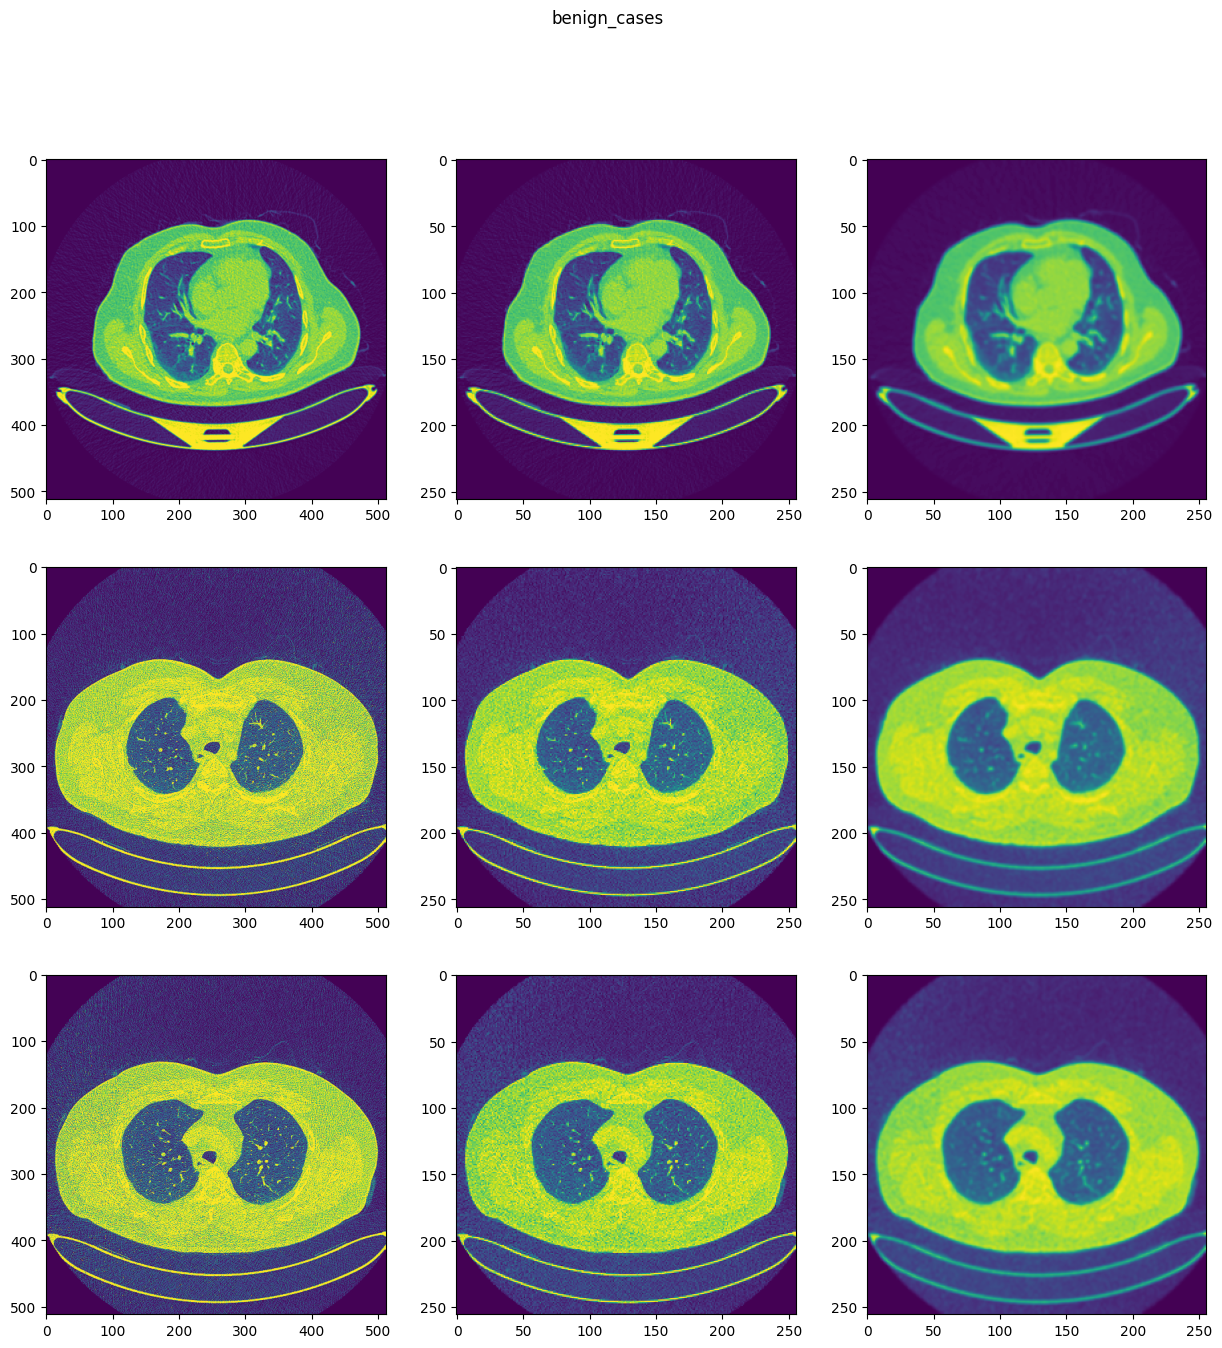

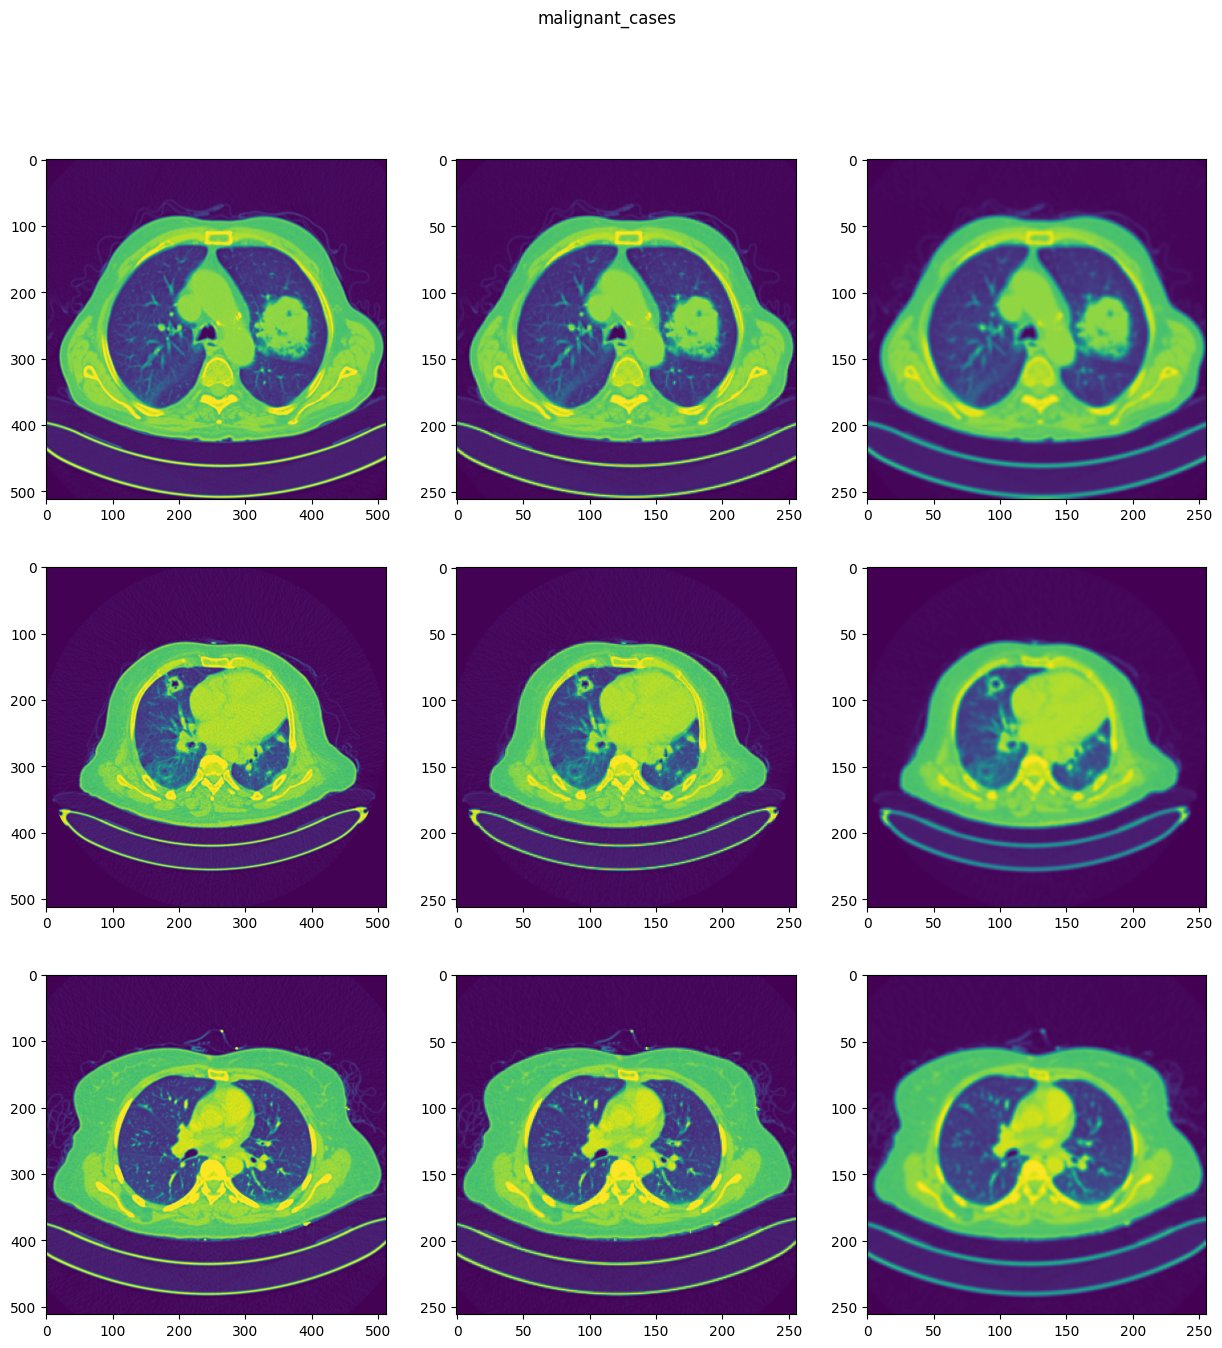

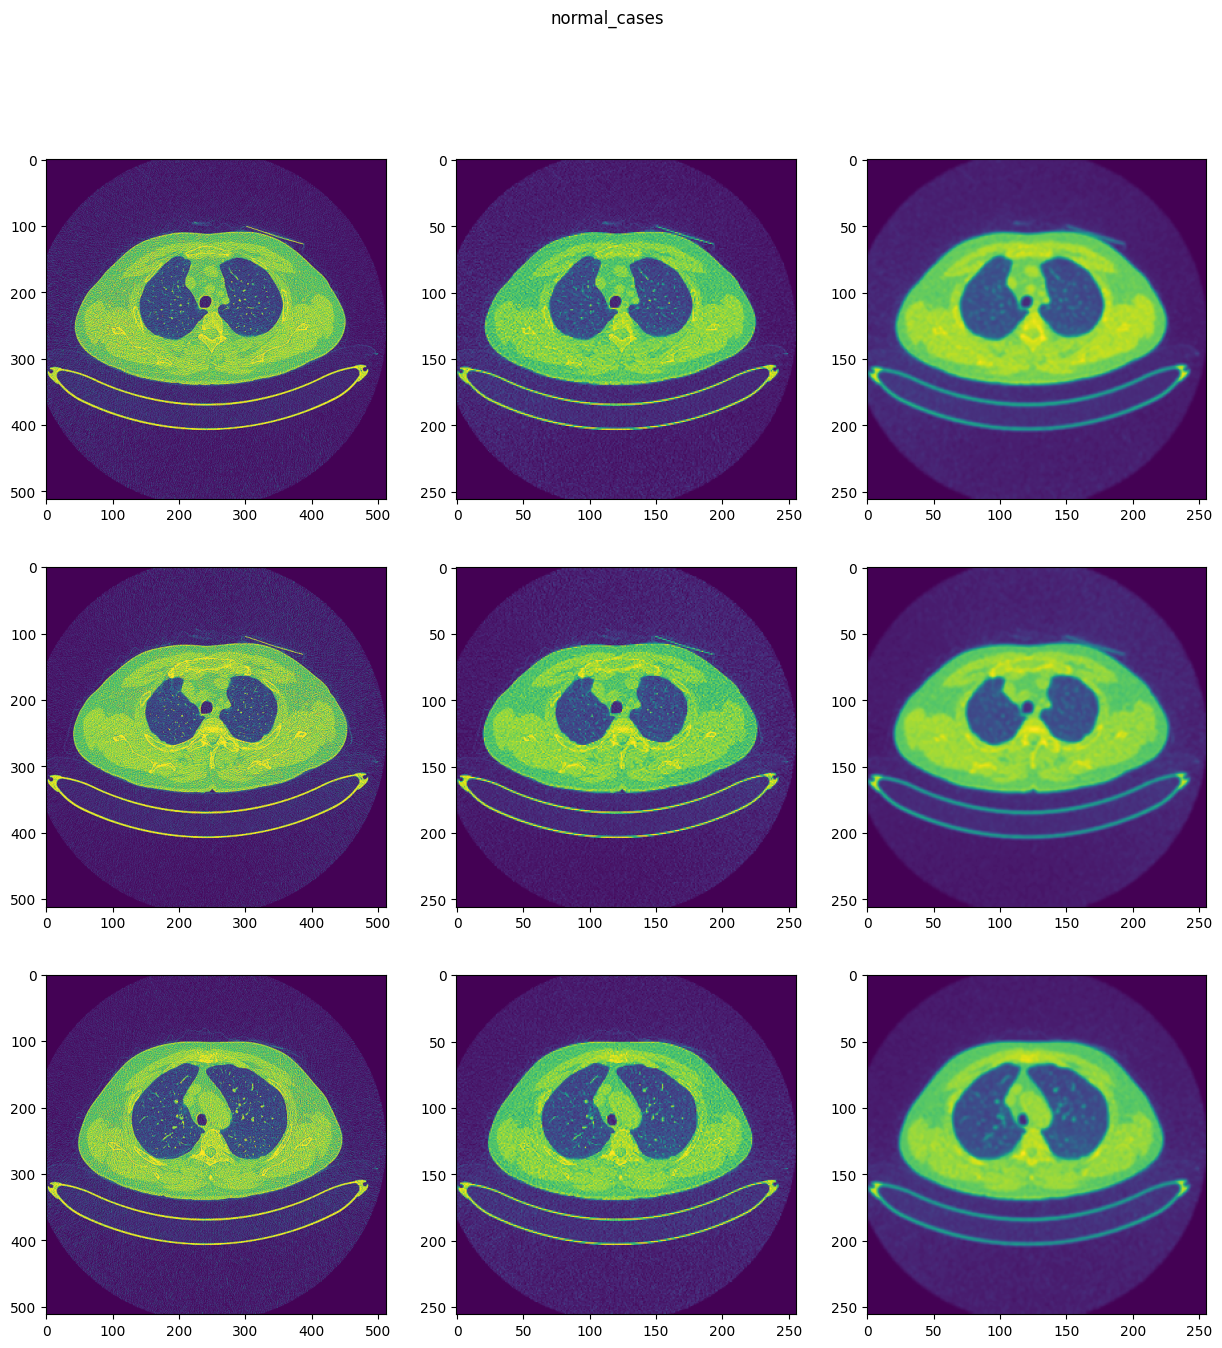

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        # file Path and reading
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # resizing
        img0 = cv2.resize(img, (img_size, img_size))
        #gaussian blurring
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

PREPARING DATA

In [ ]:
import os
import cv2
import numpy as np
from collections import Counter
import random

data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


# Splitting data

splitting data into training (70%) , testing (15%) and validation (15%)

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split into training+validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

# Step 2: Split training+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=10, stratify=y_temp)

# Print the shapes of the resulting splits
print("Training set size: ", X_train.shape, y_train.shape)
print("Validation set size: ", X_valid.shape, y_valid.shape)
print("Testing set size: ", X_test.shape, y_test.shape)


Training set size:  (575, 256, 256, 1) (575,)
Validation set size:  (192, 256, 256, 1) (192,)
Testing set size:  (330, 256, 256, 1) (330,)


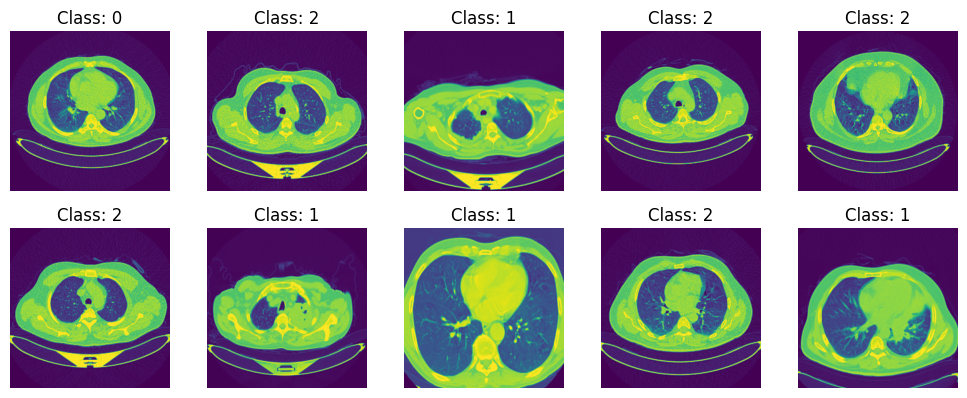

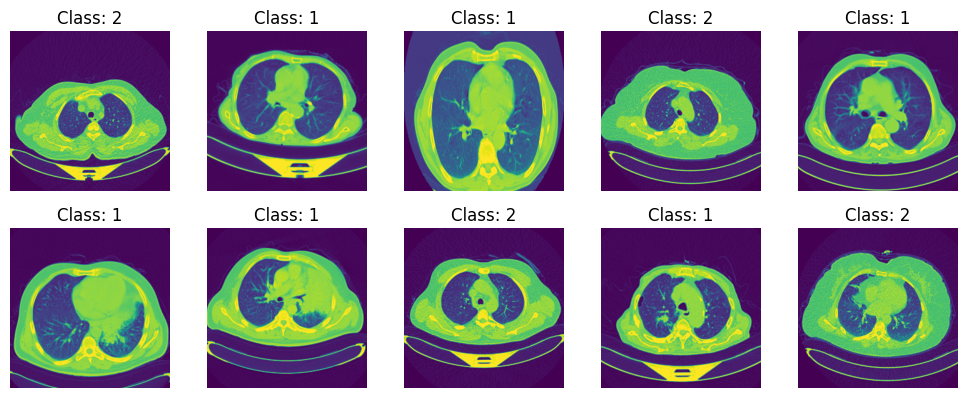

In [ ]:
# see the images

import matplotlib.pyplot as plt

# images from X_train
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
  plt.title(f"Class: {y_train[i]}")
plt.tight_layout()
plt.show()

# images from X_valid
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_valid[i])
    plt.axis('off')
    plt.title(f"Class: {y_valid[i]}")
plt.tight_layout()
plt.show()

# SMOTE approach


SMOTE to oversample the data

In [ ]:
from collections import Counter
print(Counter(y_train), Counter(y_valid))

Counter({1: 294, 2: 218, 0: 63}) Counter({1: 98, 2: 73, 0: 21})


In [ ]:
print(len(X_train), X_train.shape)
X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)
print(len(X_train), X_train.shape)

575 (575, 256, 256, 1)
575 (575, 65536)


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 294, 2: 218, 0: 63})
After SMOTE: Counter({0: 294, 2: 294, 1: 294})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

575 (575, 256, 256, 1)
882 (882, 256, 256, 1)


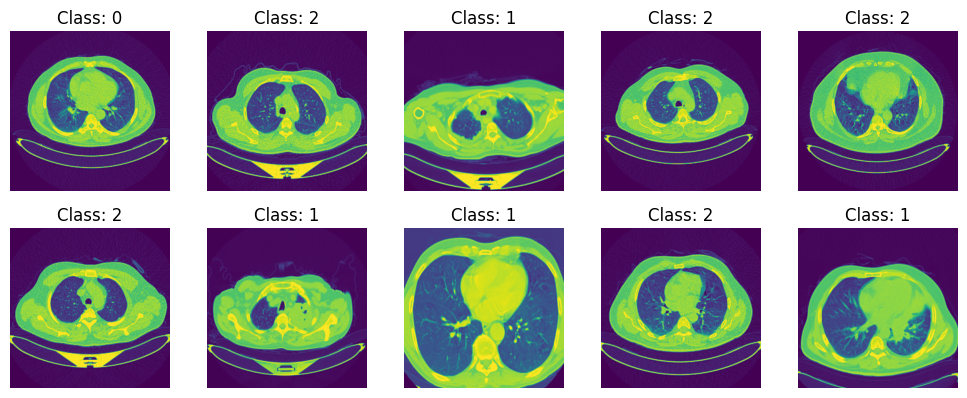

In [ ]:
# Display images from X_train_sampled
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train_sampled[i])
    plt.axis('off')
    plt.title(f"Class: {y_train_sampled[i]}")
plt.tight_layout()
plt.show()

Model building with SMOTE data

In [ ]:
# callbacks for deep learning model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Model Checkpoint - save model's weights during training
checkpoint_path = "/content/MyDrive/MyDrive/IQ-OTHNCCD_lung_cancer_dataset/lung_cancer_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# early stopping - training stops if monitored metric (e.g., val_loss) doesnt improve , helps prevent overfitting and saves training time
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights=True)

# ReduceLROnPlateau - reduce the learning rate when the monitored metric (e.g., val_loss) has stopped improving, which can help the model converge more smoothly
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

deep learning model using the EfficientNetB7 architecture as a feature extractor (pre-trained on ImageNet), followed by custom layers to perform classification

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
import numpy as np

smote_model = Sequential()

smote_model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
smote_model.add(Activation('relu'))
smote_model.add(MaxPooling2D(pool_size=(2, 2)))

smote_model.add(Conv2D(64, (3, 3), activation='relu'))
smote_model.add(MaxPooling2D(pool_size=(2, 2)))

smote_model.add(Flatten())
smote_model.add(Dense(16))
smote_model.add(Dense(3, activation='softmax'))

smote_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 254, 254, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │       3,936,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,973,891 (15.16 MB)

 Trainable params: 3,973,891 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras import optimizers

# Compile the model
smote_model.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [ ]:
# Train the model

history = smote_model.fit(
    X_train_sampled,
    y_train_sampled,
    batch_size=8,
    epochs=15,
    validation_data=(X_valid, y_valid),
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
    )

Epoch 1/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5362 - loss: 1.6210 - val_accuracy: 0.9115 - val_loss: 0.2832 - learning_rate: 0.0010
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9690 - loss: 0.1007 - val_accuracy: 0.9635 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9959 - loss: 0.0184 - val_accuracy: 0.9635 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9990 - loss: 0.0093 - val_accuracy: 0.9792 - val_loss: 0.0776 - learning_rate: 0.0010
Epoch 5/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9995 - loss: 0.0084 - val_accuracy: 0.9740 - val_loss: 0.1061 - learning_rate: 0.0010
Epoch 6/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9996 - loss: 0.0032 - val_accuracy: 0.9740 - val_loss: 0.1229 - learning_rate: 0.0010
Epoch 7/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9948 - loss: 0.

RESULTS

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = smote_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_bool)
print(f"Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step
Accuracy: 0.9848


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_bool))
print(confusion_matrix(y_true=y_test, y_pred=y_pred_bool))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.99      1.00      1.00       169
           2       0.99      0.97      0.98       125

    accuracy                           0.98       330
   macro avg       0.97      0.98      0.97       330
weighted avg       0.99      0.98      0.98       330

[[ 35   0   1]
 [  0 169   0]
 [  3   1 121]]


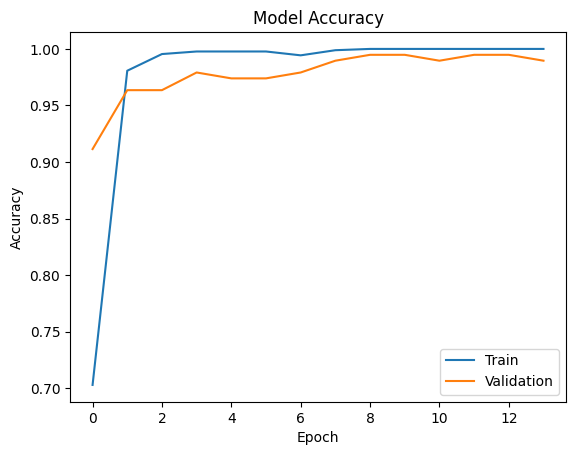

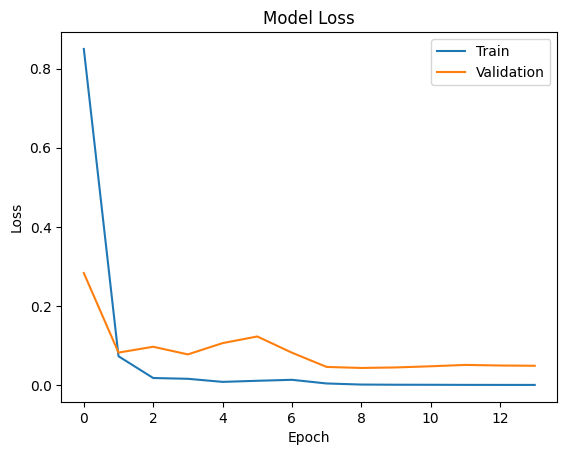

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

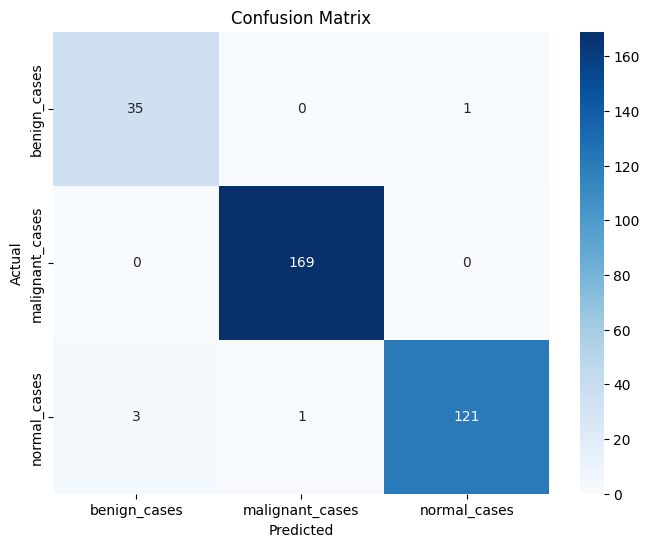

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# MODEL BUILDING WITH CLASS WEIGHTED APPROACH

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
import numpy as np

weighted_model = Sequential()

weighted_model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
weighted_model.add(Activation('relu'))
weighted_model.add(MaxPooling2D(pool_size=(2, 2)))

weighted_model.add(Conv2D(64, (3, 3), activation='relu'))
weighted_model.add(MaxPooling2D(pool_size=(2, 2)))

weighted_model.add(Flatten())
weighted_model.add(Dense(16))
weighted_model.add(Dense(3, activation='softmax'))

weighted_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 254, 254, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 125, 125, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │       3,936,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,973,891 (15.16 MB)

 Trainable params: 3,973,891 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
weighted_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}
new_weights

{0: 3.0423280423280423, 1: 0.6519274376417233, 2: 0.8792048929663608}

In [ ]:
history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=15,
    validation_data=(X_valid, y_valid),
    class_weight=new_weights,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
    )

Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4690 - loss: 4.3031 - val_accuracy: 0.6458 - val_loss: 0.9094 - learning_rate: 0.0010
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7462 - loss: 0.7758 - val_accuracy: 0.8906 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9730 - loss: 0.1134 - val_accuracy: 0.9479 - val_loss: 0.1803 - learning_rate: 0.0010
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9871 - loss: 0.0935 - val_accuracy: 0.9219 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9911 - loss: 0.0479 - val_accuracy: 0.9844 - val_loss: 0.0813 - learning_rate: 0.0010
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9988 - loss: 0.0105 - val_accuracy: 0.9844 - val_loss: 0.0413 - learning_rate: 0.0010
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9978 - loss: 0.0099 - val_acc

RESULTS

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = weighted_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_bool)
print(f"Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Accuracy: 0.9636


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_bool))
print(confusion_matrix(y_true=y_test, y_pred=y_pred_bool))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        36
           1       0.97      0.99      0.98       169
           2       0.98      0.94      0.96       125

    accuracy                           0.96       330
   macro avg       0.95      0.95      0.95       330
weighted avg       0.96      0.96      0.96       330

[[ 33   2   1]
 [  0 167   2]
 [  3   4 118]]


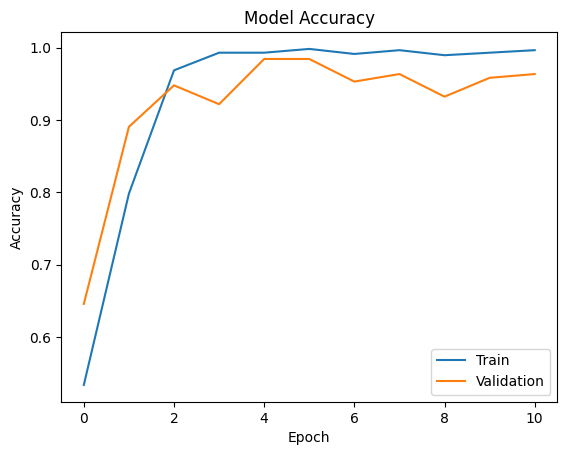

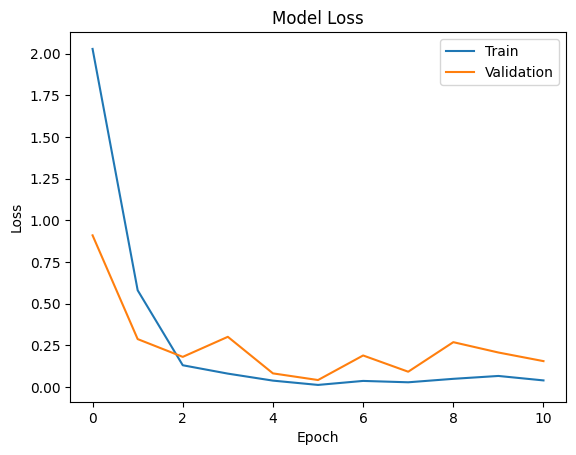

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


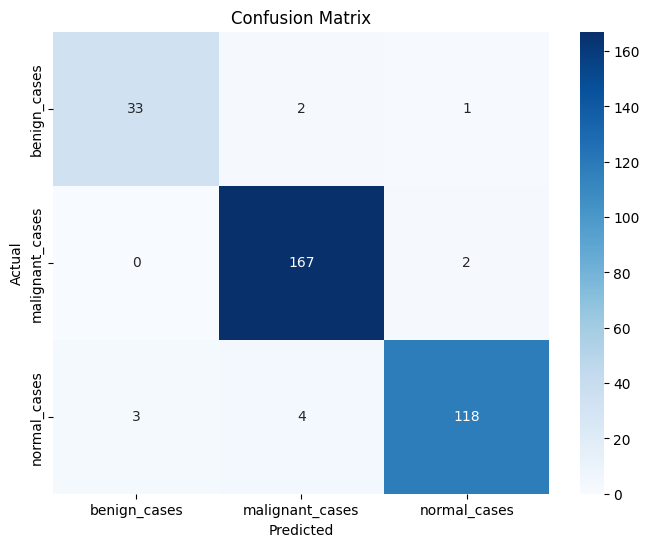

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# DATA AUGMENTATION


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data augmentation
train_datagen = ImageDataGenerator(
    shear_range=0.1,                # Apply shear transformations (shearing angle)
    zoom_range=0.1,                 # Random zooming
    horizontal_flip=True,           # Randomly flip images horizontally
    vertical_flip=True,             # Randomly flip images vertically
    rotation_range=10,              # Random rotations up to 30 degrees
    fill_mode='nearest'             # Fill missing pixels after transformations
)

# Validation data preprocessing (no augmentation)
val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
import numpy as np

augmented_model = Sequential()

augmented_model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
augmented_model.add(Activation('relu'))
augmented_model.add(MaxPooling2D(pool_size=(2, 2)))

augmented_model.add(Conv2D(64, (3, 3), activation='relu'))
augmented_model.add(MaxPooling2D(pool_size=(2, 2)))

augmented_model.add(Flatten())
augmented_model.add(Dense(16))
augmented_model.add(Dense(3, activation='softmax'))

augmented_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 254, 254, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 16)                  │       3,936,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,973,891 (15.16 MB)

 Trainable params: 3,973,891 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
augmented_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = augmented_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
   )

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.5106 - loss: 1.7527 - val_accuracy: 0.6875 - val_loss: 0.8765 - learning_rate: 0.0010
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6356 - loss: 0.8749 - val_accuracy: 0.7188 - val_loss: 0.7487 - learning_rate: 0.0010
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6354 - loss: 0.8321 - val_accuracy: 0.7292 - val_loss: 0.7130 - learning_rate: 0.0010
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6310 - loss: 0.8063 - val_accuracy: 0.7135 - val_loss: 0.7235 - learning_rate: 0.0010
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7090 - loss: 0.7425 - val_accuracy: 0.6823 - val_loss: 0.7327 - learning_rate: 0.0010
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6584 - loss: 0.7804 - val_accuracy: 0.7135 - val_loss: 0.7048 - learning_rate: 0.0010
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7027 - loss: 0.7340 - val_acc

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = augmented_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_bool)
print(f"Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
Accuracy: 0.8303


In [ ]:
print(classification_report(y_test, y_pred_bool))
print(confusion_matrix(y_true=y_test, y_pred=y_pred_bool))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52        36
           1       0.90      0.92      0.91       169
           2       0.80      0.82      0.81       125

    accuracy                           0.83       330
   macro avg       0.76      0.74      0.74       330
weighted avg       0.82      0.83      0.83       330

[[ 17   1  18]
 [  7 155   7]
 [  6  17 102]]


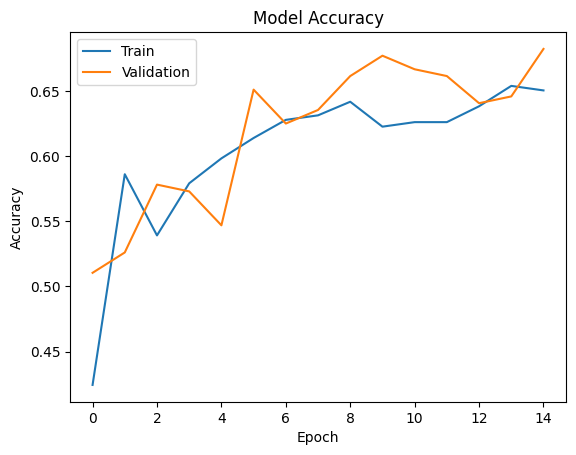

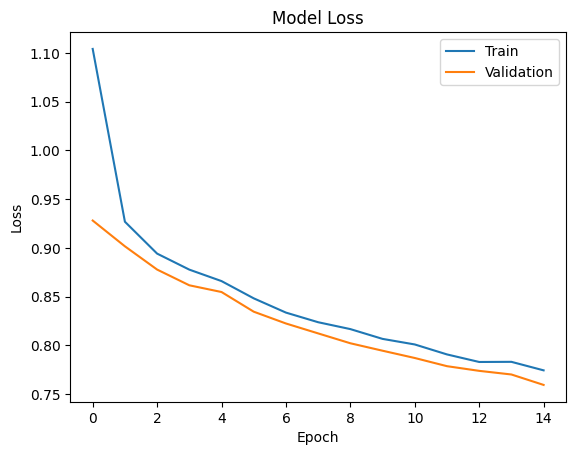

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

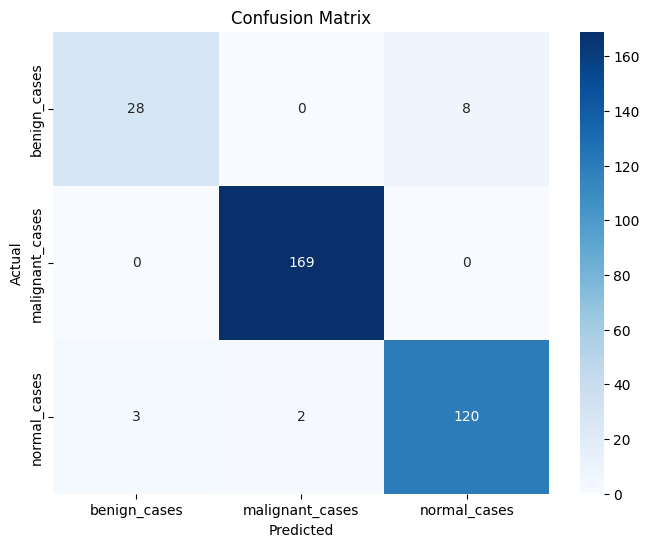

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Model with Transfer learning

Advanced Architectures: ResNet and EfficientNet                    
Instead of building a custom model, use pre-trained models like ResNet or
            EfficientNet and fine-tune them

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Custom fully connected layer
output = Dense(3, activation='softmax')(x)  # Output layer for 3 classes

resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


FINE TUNE MODEL

Train the Custom Layers (Feature Extraction):            

Use the frozen base model and train only the custom layers you added. This will allow the model to learn features specific to your dataset without altering the pre-trained weights.

In [ ]:
import tensorflow as tf

# Convert grayscale images to RGB
X_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train))
X_valid_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_valid))

# Verify the shapes
print(X_train_rgb.shape)  # Should be (num_samples, 256, 256, 3)
print(X_valid_rgb.shape)  # Should be (num_samples, 256, 256, 3)


(575, 256, 256, 3)
(192, 256, 256, 3)


In [ ]:
X_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test))


In [ ]:
# Train the model
history = resnet_model.fit(X_train_rgb, y_train,
                           validation_data=(X_valid_rgb, y_valid),
                           epochs=15,
                           batch_size=32,
                           shuffle = True,
                           )

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 877ms/step - accuracy: 0.3099 - loss: 1.2818 - val_accuracy: 0.5104 - val_loss: 0.9280
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.5675 - loss: 0.9507 - val_accuracy: 0.5260 - val_loss: 0.9016
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5313 - loss: 0.8825 - val_accuracy: 0.5781 - val_loss: 0.8777
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6104 - loss: 0.8790 - val_accuracy: 0.5729 - val_loss: 0.8615
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5512 - loss: 0.9017 - val_accuracy: 0.5469 - val_loss: 0.8546
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5854 - loss: 0.8693 - val_accuracy: 0.6510 - val_loss: 0.8345
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6163 - loss: 0.8516 - val_accuracy: 0.6250 - val_loss: 0.8224
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.6295 - loss: 0.8480 - val_accuracy: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = resnet_model.predict(X_test_rgb , verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


report = classification_report(y_test, y_pred_bool)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)
print(report)
print(conf_mat)

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 602ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.74      0.82      0.78       169
           2       0.61      0.69      0.64       125

    accuracy                           0.68       330
   macro avg       0.45      0.50      0.47       330
weighted avg       0.61      0.68      0.64       330

[[  0  10  26]
 [  0 139  30]
 [  0  39  86]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Unfreeze Some Layers for Fine-Tuning:

After the initial training, unfreeze some of the top layers in the base model to fine-tune them on your dataset.
Lower the learning rate to avoid large updates that could erase pre-trained weights

In [ ]:
# Unfreeze top layers of the base model
for layer in base_model.layers[-20:]:  # Adjust number of layers as needed
    layer.trainable = True

# Recompile the model with a lower learning rate
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Fine-tune the model
history_fine = resnet_model.fit(X_train_rgb ,y_train,
                                validation_data=(X_valid_rgb ,y_valid),
                                epochs=30,
                                batch_size=32,
                                shuffle = True,
                                )

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 731ms/step - accuracy: 0.6320 - loss: 0.7870 - val_accuracy: 0.6615 - val_loss: 0.7465
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.8518 - loss: 0.4534 - val_accuracy: 0.6667 - val_loss: 0.7588
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9214 - loss: 0.2958 - val_accuracy: 0.6250 - val_loss: 0.8138
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.9521 - loss: 0.2294 - val_accuracy: 0.5312 - val_loss: 0.9143
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.9649 - loss: 0.1727 - val_accuracy: 0.4323 - val_loss: 1.0274
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.9708 - loss: 0.1433 - val_accuracy: 0.4115 - val_loss: 1.1056
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.9882 - loss: 0.1070 - val_accuracy: 0.4062 - val_loss: 1.1298
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9870 - loss: 0.0875 - val_accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = resnet_model.predict(X_test_rgb, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_bool)
print(f"Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step
Accuracy: 0.9606


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


report = classification_report(y_test, y_pred_bool)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)
print(report)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.90      0.78      0.84        36
           1       0.99      1.00      0.99       169
           2       0.94      0.96      0.95       125

    accuracy                           0.96       330
   macro avg       0.94      0.91      0.93       330
weighted avg       0.96      0.96      0.96       330

[[ 28   0   8]
 [  0 169   0]
 [  3   2 120]]


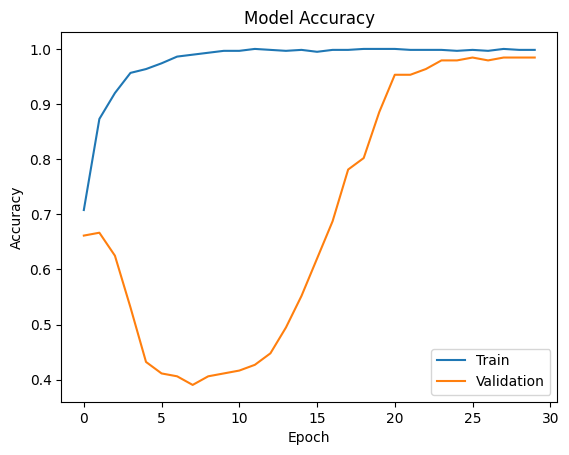

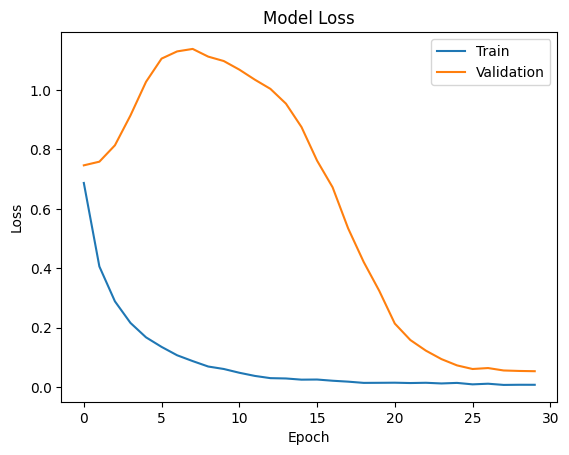

In [ ]:
# Plot model accuracy
import matplotlib.pyplot as plt
plt.plot(history_fine.history['accuracy'], label='Train')
plt.plot(history_fine.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot model loss
plt.plot(history_fine.history['loss'], label='Train')
plt.plot(history_fine.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


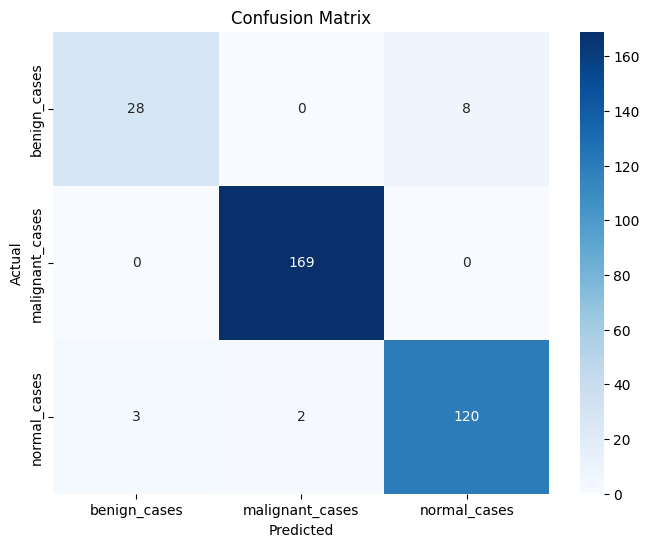

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow as tf  # For saving the model
from google.colab import files  # For downloading files in Google Colab


resnet_model.save("resnet_model.h5")
files.download("resnet_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hamdallak/the-iqothnccd-lung-cancer-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/versions/1
